# Model 2 (XGBoost)

## Importing necessary libraries

* `pandas`, `numpy`: data manipulation <br>
* `matplotlib`, `seaborn`: visualizations <br>
* `sklearn`: ML and deep learning frameworks <br>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import tensorflow as tf
import os 
import xgboost as xgb

%load_ext autoreload
%autoreload 2


## Fetching data from Kaggle

In [2]:
from utilities.data_util import fetch_data

DATASET_NAME = "sid321axn/beijing-multisite-airquality-data-set"
DOWNLOAD_DIR = os.path.join(os.getcwd(), 'data')

from utilities.data_util import fetch_data

fetch_data(DATASET_NAME, DOWNLOAD_DIR)



KAGGLE_CONFIG_DIR set to: /Users/serhanasad/Desktop/ML/final/4641_Group/secrets
Dataset URL: https://www.kaggle.com/datasets/sid321axn/beijing-multisite-airquality-data-set
Dataset downloaded and unzipped to /Users/serhanasad/Desktop/ML/final/4641_Group/Midterm/data
Created .gitignore in /Users/serhanasad/Desktop/ML/final/4641_Group/Midterm/data


### Merging datasets

In [3]:
data_folder = os.path.join(os.getcwd(), 'data')
print(os.getcwd())

print("data_folder", data_folder)
all_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.csv')]

combined_data = pd.concat((pd.read_csv(file) for file in all_files), ignore_index=True)


print("shape" ,combined_data.shape)

combined_data.to_csv(os.path.join(data_folder, 'combined_data.csv'), index=False)

/Users/serhanasad/Desktop/ML/final/4641_Group/Midterm
data_folder /Users/serhanasad/Desktop/ML/final/4641_Group/Midterm/data
shape (5049216, 18)


In [4]:
data = pd.read_csv('data/combined_data.csv')
print("Shape:", data.shape)
data.head()

Shape: (5049216, 18)


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,6.0,18.0,5.0,NaN,800.0,88.0,0.1,1021.1,-18.6,0.0,NW,4.4,Gucheng
1,2,2013,3,1,1,6.0,15.0,5.0,NaN,800.0,88.0,-0.3,1021.5,-19.0,0.0,NW,4.0,Gucheng
2,3,2013,3,1,2,5.0,18.0,NaN,NaN,700.0,52.0,-0.7,1021.5,-19.8,0.0,WNW,4.6,Gucheng
3,4,2013,3,1,3,6.0,20.0,6.0,NaN,NaN,NaN,-1.0,1022.7,-21.2,0.0,W,2.8,Gucheng
4,5,2013,3,1,4,5.0,17.0,5.0,NaN,600.0,73.0,-1.3,1023.0,-21.4,0.0,WNW,3.6,Gucheng


In [5]:
data.info()

missing = data.isnull().sum()
print(missing[missing > 0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5049216 entries, 0 to 5049215
Data columns (total 18 columns):
 #   Column   Dtype  
---  ------   -----  
 0   No       int64  
 1   year     int64  
 2   month    int64  
 3   day      int64  
 4   hour     int64  
 5   PM2.5    float64
 6   PM10     float64
 7   SO2      float64
 8   NO2      float64
 9   CO       float64
 10  O3       float64
 11  TEMP     float64
 12  PRES     float64
 13  DEWP     float64
 14  RAIN     float64
 15  wd       object 
 16  WSPM     float64
 17  station  object 
dtypes: float64(11), int64(5), object(2)
memory usage: 693.4+ MB
PM2.5    104868
PM10      77388
SO2      108252
NO2      145392
CO       248412
O3       159324
TEMP       4776
PRES       4716
DEWP       4836
RAIN       4680
wd        21864
WSPM       3816
dtype: int64


In [6]:
print(data.head())
print(data.info())         # look for nulls, dtypes
print(data.describe())     # numeric summaries

   No  year  month  day  hour  PM2.5  PM10  SO2  NO2     CO    O3  TEMP  \
0   1  2013      3    1     0    6.0  18.0  5.0  NaN  800.0  88.0   0.1   
1   2  2013      3    1     1    6.0  15.0  5.0  NaN  800.0  88.0  -0.3   
2   3  2013      3    1     2    5.0  18.0  NaN  NaN  700.0  52.0  -0.7   
3   4  2013      3    1     3    6.0  20.0  6.0  NaN    NaN   NaN  -1.0   
4   5  2013      3    1     4    5.0  17.0  5.0  NaN  600.0  73.0  -1.3   

     PRES  DEWP  RAIN   wd  WSPM  station  
0  1021.1 -18.6   0.0   NW   4.4  Gucheng  
1  1021.5 -19.0   0.0   NW   4.0  Gucheng  
2  1021.5 -19.8   0.0  WNW   4.6  Gucheng  
3  1022.7 -21.2   0.0    W   2.8  Gucheng  
4  1023.0 -21.4   0.0  WNW   3.6  Gucheng  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5049216 entries, 0 to 5049215
Data columns (total 18 columns):
 #   Column   Dtype  
---  ------   -----  
 0   No       int64  
 1   year     int64  
 2   month    int64  
 3   day      int64  
 4   hour     int64  
 5   PM2.5    floa

In [ ]:
import pprint
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

# print(type(data))



target = "PM2.5"
data = data.dropna(subset=[target]).copy()

features = ['SO2','NO2','CO','O3','TEMP','PRES','DEWP','RAIN','WSPM','year','month','day','hour']
X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)




Predictions: [139.94963   275.12537    39.96083    41.37873     6.1661925]
Actual: [ 88. 236.  62.  27.   9.]


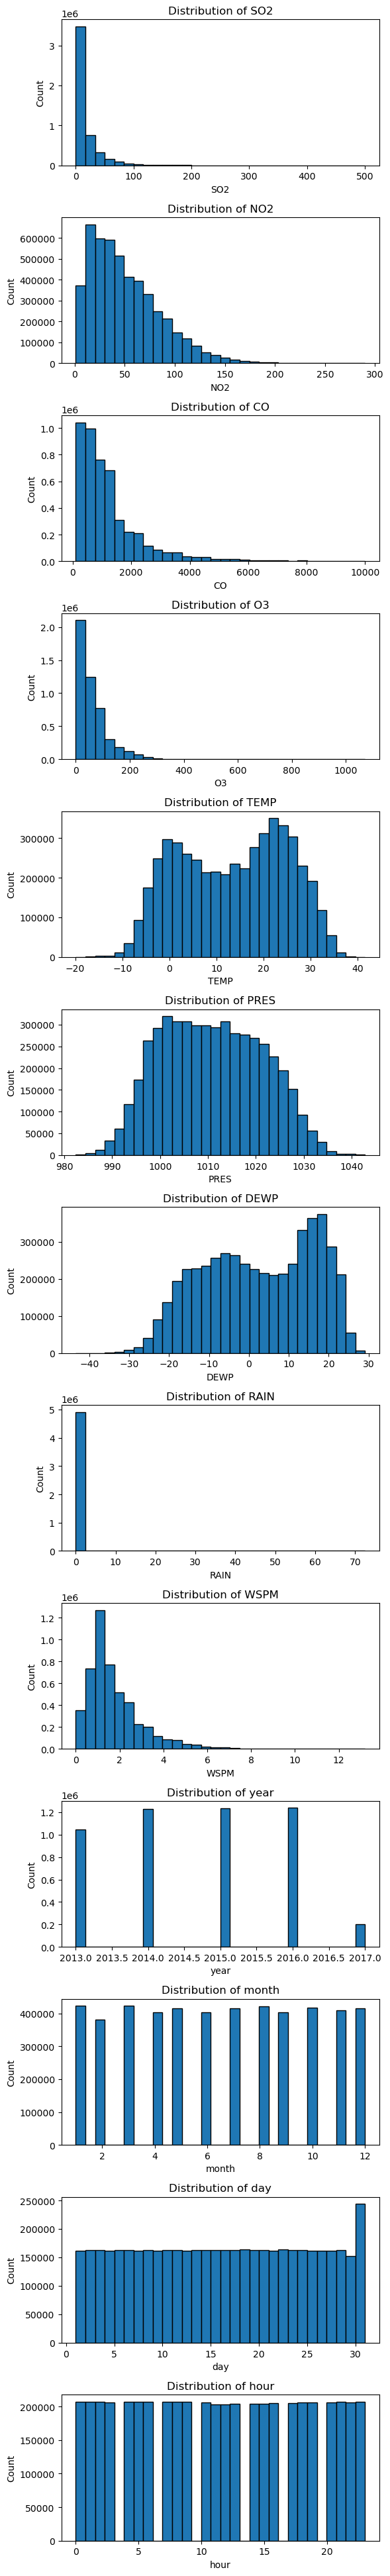

In [22]:
fig, axes = plt.subplots(len(features), 1, figsize=(6, 3 * len(features)))
for ax, col in zip(axes, features):
    ax.hist(data[col].dropna(), bins=30, edgecolor='black')
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Count')
plt.tight_layout()
plt.show()


<Figure size 800x800 with 0 Axes>

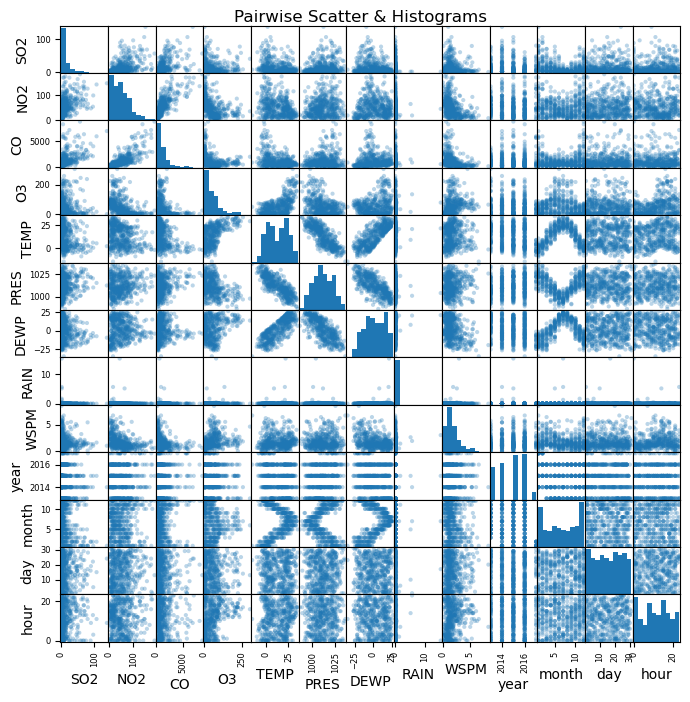

In [ ]:
from pandas.plotting import scatter_matrix

subset = data[features].sample(500, random_state=1)
fig = plt.figure(figsize=(8, 8))
axes = scatter_matrix(subset, alpha=0.3, diagonal='hist', figsize=(8, 8))
for ax in axes.flatten():
    ax.tick_params(labelsize=6)
plt.suptitle('Pairwise Scatter & Histograms', y=0.9)
plt.show()


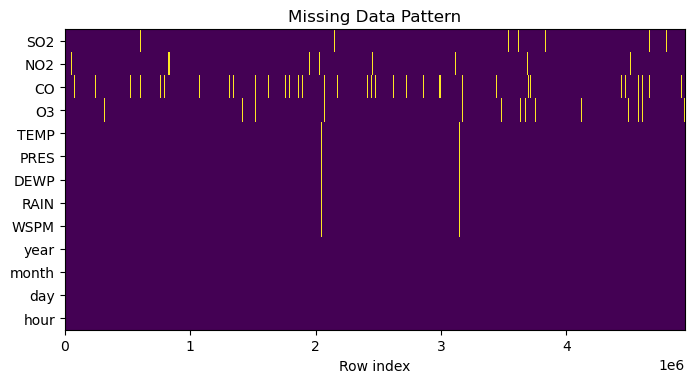

In [ ]:

mask = data[features].isnull().to_numpy().T
fig, ax = plt.subplots(figsize=(8, len(features) * 0.3))
ax.imshow(mask, aspect='auto', interpolation='none')
ax.set_yticks(np.arange(len(features)))
ax.set_yticklabels(features)
ax.set_xlabel('Row index')
ax.set_title('Missing Data Pattern')
plt.show()


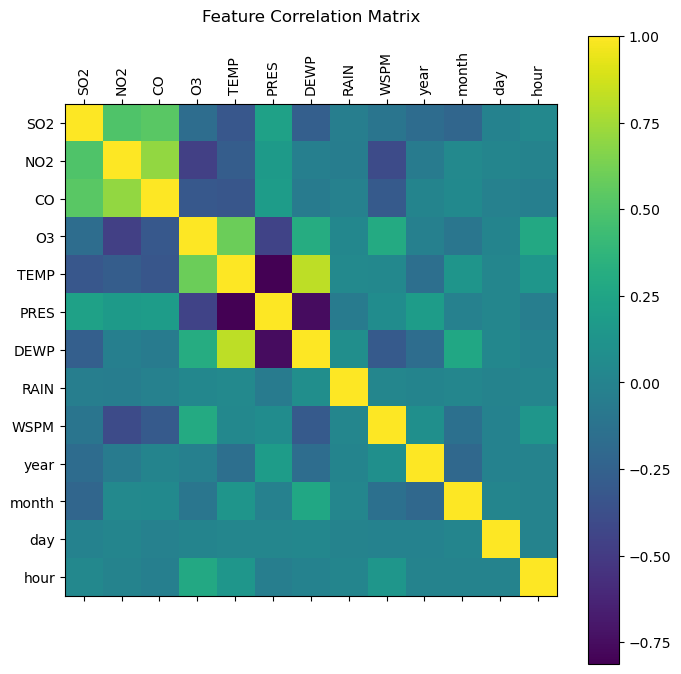

In [27]:
corr = data[features].corr()
fig, ax = plt.subplots(figsize=(7, 7))
cax = ax.matshow(corr)
fig.colorbar(cax)
ax.set_xticks(range(len(features)))
ax.set_xticklabels(features, rotation=90)
ax.set_yticks(range(len(features)))
ax.set_yticklabels(features)
ax.set_title('Feature Correlation Matrix', pad=20)
plt.tight_layout()
plt.show()


In [19]:
#instantiate and fit the model
model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    verbosity=1
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Predictions:", y_pred[:5])
print("Actual:", y_test[:5].values.flatten())

# pprint.pprint(data)


KeyboardInterrupt: 

In [ ]:
#instantiate and fit the model
model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    verbosity=1
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("Predictions:", y_pred[:5])
print("Actual:", y_test[:5].values.flatten())

# pprint.pprint(data)


In [ ]:
######WARNING############################################################################################

#This cell attempts to run cross validation for 20 iterations
#be weary that it may take a while to run 
#It took my beast of a PC 23 minutes to get through 20 iterations


import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error

# prepare data, drop rows with missing target feature values
#XGBoost is great at handling missing values so we only worry about the target missing values
df = data.dropna(subset=['PM2.5']).copy()

# — EPA breakpoints for subindex calculation
breakpoints = {
    'CO': [
        (  0.0,    4.4,    0,   50),
        (  4.5,    9.4,   51,  100),
        (  9.5,   12.4,  101,  150),
        ( 12.5,   15.4,  151,  200),
        ( 15.5,   30.4,  201,  300),
        ( 30.5,   40.4,  301,  400),
        ( 40.5,   50.4,  401,  500),
    ],
    'SO2': [
        (   0,     35,    0,   50),
        (  36,     75,   51,  100),
        (  76,    185,  101,  150),
        ( 186,    304,  151,  200),
        ( 305,    604,  201,  300),
        ( 605,    804,  301,  400),
        ( 805,   1004,  401,  500),
    ],
    'NO2': [
        (   0,     53,    0,   50),
        (  54,    100,   51,  100),
        ( 101,    360,  101,  150),
        ( 361,    649,  151,  200),
        ( 650,   1249,  201,  300),
        (1250,   1649,  301,  400),
        (1650,   2049,  401,  500),
    ],
    'O3': [
        (  0.0,   54.0,   0,   50),
        ( 55.0,   70.0,  51,  100),
        ( 71.0,   85.0, 101,  150),
        ( 86.0,  105.0, 151,  200),
        (106.0,  200.0, 201,  300),
        (201.0,  300.0, 301,  400),
        (301.0,  604.0, 401,  500),
    ],
}



def compute_subindex(col, bps):
    idx = pd.Series(index=col.index, dtype='float32')
    for Clow, Chigh, Ilow, Ihigh in bps:
        m = col.between(Clow, Chigh)
        idx.loc[m] = ((Ihigh - Ilow)/(Chigh - Clow)) * (col[m] - Clow) + Ilow
    return idx

polls = ['CO','SO2','NO2','O3']
for p in polls:
    df[f'{p}_idx'] = compute_subindex(df[p], breakpoints[p])

# — 2. Feature engineering —
df['hour_sin']   = np.sin(2*np.pi*df.hour/24)
df['hour_cos']   = np.cos(2*np.pi*df.hour/24)
df['month_sin']  = np.sin(2*np.pi*df.month/12)
df['month_cos']  = np.cos(2*np.pi*df.month/12)

# — 3. Select & encode features —
features = [
    'year','month','day','hour','SO2','NO2','CO','O3',
    'TEMP','PRES','DEWP','RAIN','WSPM','hour_sin','hour_cos','month_sin','month_cos',
    'wd','station'
]
X = pd.get_dummies(df[features], drop_first=True)
y = df['PM2.5']

# — 4. Train/test split —
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# — 5. Early stopping with core API —
dtrain = xgb.DMatrix(X_train, label=y_train)
deval  = xgb.DMatrix(X_test,  label=y_test)
params = {
    'objective':      'reg:squarederror',
    'eta':            0.05,
    'max_depth':      6,
    'subsample':      0.8,
    'colsample_bytree':0.8,
    'eval_metric':    'rmse'
}
# up to 1000 rounds, but stops when eval RMSE hasn’t improved in 10 rounds
bst = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (deval, 'eval')],
    early_stopping_rounds=10,
    verbose_eval=False
)
print("→ Best num_boost_round:", bst.best_iteration)

# — 6. Wrap into sklearn regressor for tuning —
base_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    n_estimators=bst.best_iteration,
    random_state=42
)

# — 7. Randomized hyperparameter search —
param_dist = {
    'learning_rate':   [0.01, 0.05, 0.1],
    'max_depth':       [4, 6, 8],
    'subsample':       [0.6, 0.8, 1.0],
    'colsample_bytree':[0.6, 0.8, 1.0],
    'reg_alpha':       [0, 0.1, 1],
    'reg_lambda':      [1, 5, 10]
}
rs = RandomizedSearchCV(
    base_model,
    param_dist,
    n_iter=20,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=1
)
rs.fit(X_train, y_train)
print("→ Best params:", rs.best_params_)

# — 8. Final 5‑fold CV on tuned model —
best_model = rs.best_estimator_
scores = cross_val_score(
    best_model, X, y,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
print(f"→ CV RMSE: {(-scores.mean()):.2f} ± {scores.std():.2f}")


In [9]:
"""
→ Best params: {'subsample': 1.0, 'reg_lambda': 5, 'reg_alpha': 0, 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
→ CV RMSE: 6.41 ± 0.04
"""

from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

# 1. best hyperparameters from tuning
best_params = {
    'subsample':        1.0,
    'reg_lambda':       5,
    'reg_alpha':        0,
    'max_depth':        8,
    'learning_rate':    0.1,
    'colsample_bytree': 0.8
}
dtrain = xgb.DMatrix(X_train, label=y_train)
deval  = xgb.DMatrix(X_test,  label=y_test)
bst = xgb.train(
    best_params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (deval, 'eval')],

    early_stopping_rounds=10,
    verbose_eval=False
)
# 2. Instantiate final model.
final_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=bst.best_iteration,  # e.g. from xgb.train’s best_iteration
    random_state=42,
    **best_params
)

# 3. fit the final model
final_model.fit(X_train, y_train)

# 4. predict on test set
y_pred = final_model.predict(X_test)

# 5. compute metrics
rmse = root_mean_squared_error(y_test,  y_pred)
mae  = mean_absolute_error(    y_test,  y_pred)
r2   = r2_score(               y_test,  y_pred)

print(f"Final RMSE: {rmse:.2f} µg/m³")
print(f"Final MAE:  {mae:.2f} µg/m³")
print(f"Final R²:   {r2:.3f}")


Final RMSE: 14.21 µg/m³
Final MAE:  9.56 µg/m³
Final R²:   0.969


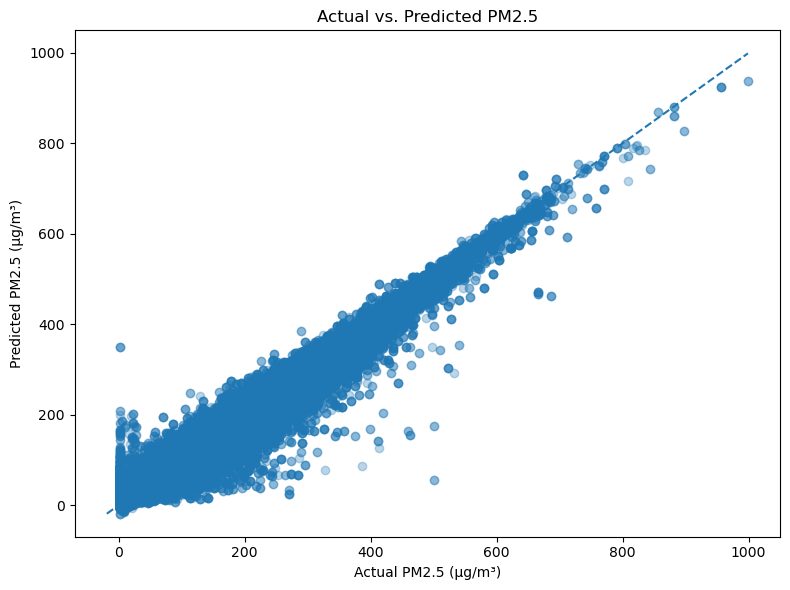

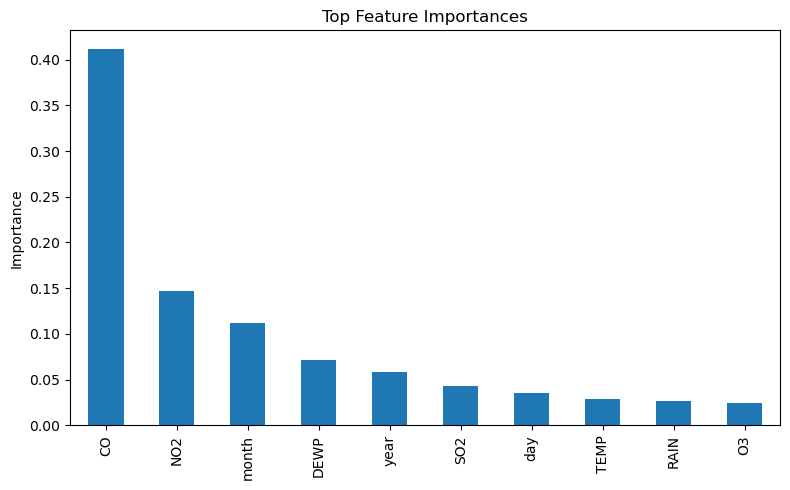

In [32]:
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. Scatter: Actual vs. Predicted ---
y_pred = final_model.predict(X_test)

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.3)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--')
plt.xlabel('Actual PM2.5 (µg/m³)')
plt.ylabel('Predicted PM2.5 (µg/m³)')
plt.title('Actual vs. Predicted PM2.5')
plt.tight_layout()
plt.show()

# --- 2. Bar: Top 10 Feature Importances ---
importances = pd.Series(final_model.feature_importances_, index=X_train.columns)
top10 = importances.sort_values(ascending=False).head(10)

plt.figure(figsize=(8,5))
top10.plot(kind='bar')
plt.ylabel('Importance')
plt.title('Top Feature Importances')
plt.tight_layout()
plt.show()


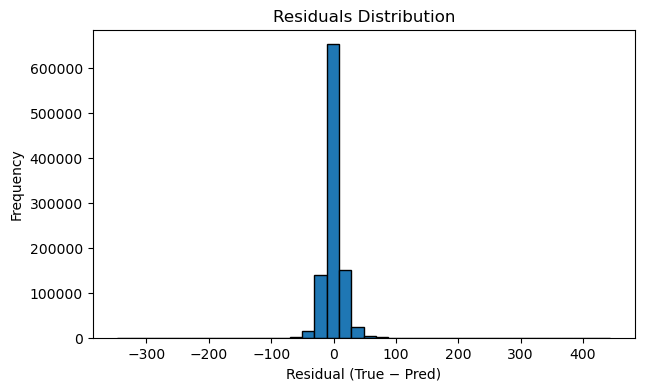

In [13]:
residuals = y_test - y_pred
fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(residuals, bins=40, edgecolor='black')
ax.set_xlabel('Residual (True − Pred)')
ax.set_ylabel('Frequency')
ax.set_title('Residuals Distribution')
plt.show()
